## Метрика оценивания соревнования на Kaggle

Метрикой оценки является площадь под ROC-кривой(**ROC-AUC**).

## Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import matplotlib.pyplot as plt
import warnings

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

from catboost import CatBoostClassifier

from lightgbm import LGBMClassifier, plot_importance

from xgboost import XGBClassifier

warnings.filterwarnings('ignore') 

In [2]:
sns.set(rc={'figure.figsize' : (9, 6)})
sns.set_style("ticks") 

# Предобработка данных

## Загрузка данных

In [3]:
train_df = pd.read_csv('data/preprocessed_data/preprocessed_train.csv')
test_df = pd.read_csv('data/preprocessed_data/preprocessed_test.csv')
submission = pd.read_csv('data/preprocessed_data/submission.csv')

In [4]:
train_df.head()

,Geography_Germany,Geography_Spain,Gender_Male,Age,Tenure,Balance,CreditScore,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,IsActiveByCrCard,TenureAgeRatio,Exited
0,False,False,True,33.0,3,0.00,668,2,1.0,0.0,181449.97,0.0,0.090909,0
1,False,False,True,33.0,1,0.00,627,2,1.0,1.0,49503.50,1.0,0.030303,0
2,False,False,True,40.0,10,0.00,678,2,1.0,0.0,184866.69,0.0,0.250000,0
3,False,False,True,34.0,2,148882.54,581,1,1.0,1.0,84560.88,1.0,0.058824,0
4,False,True,True,33.0,5,0.00,716,2,1.0,1.0,15068.83,1.0,0.151515,0


## Функции

### Функция для кросс-валидации

In [5]:
def find_best_parameters(X_train, y_train, model):

    if 'XGB' or 'LGBM' in str(model.__class__):
        parameters = {'iterations' : range(200, 500, 100),
                      'learning_rate': [0.01, 0.05, 0.1],
                      'max_depth': range(3, 9, 3),
                      'reg_lambda': range(1, 7, 2)}
    else:
        parameters = {'iterations' : range(200, 500, 100),
                      'learning_rate': [0.01, 0.05, 0.1],
                      'max_depth': range(3, 9, 3),
                      'l2_leaf_reg': range(1, 7, 2)}

    kf = StratifiedKFold(n_splits=10,
                         shuffle=True,
                         random_state=42)

    grid_search_cv = GridSearchCV(estimator=model,
                                  param_grid=parameters,
                                  cv=kf,
                                  scoring='roc_auc',
                                  n_jobs=3,
                                  verbose=0)

    grid_search_cv.fit(X_train, y_train, eval_set=[(X_val, y_val)])
    
    return grid_search_cv.best_estimator_, grid_search_cv.best_params_

### Функция для вывода метрик

In [6]:
def metrics_summary(y_pred, y_pred_proba, model):
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'Precision: {precision_score(y_test, y_pred)}')
    print(f'Recall: {recall_score(y_test, y_pred)}')
    print(f'F1: {f1_score(y_test, y_pred)}')
    print(f'\033[4mROC-AUC\033[0m: {roc_auc_score(y_test, y_pred_proba)}')

    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred, labels=model.classes_),
                                  display_labels=model.classes_)
    disp.plot()
    plt.show()

## Разделение данных на тренировочную, валидационную и тестовую выборки

In [7]:
X = train_df.drop(['Exited'], axis = 1)
y = train_df['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# Построение моделей

## XGBoost

### Подбор параметров

In [ ]:
xgb_clf = XGBClassifier(verbosity=0)
start_time = time.time()
best_xgb_clf, best_xgb_params = find_best_parameters(X_train, y_train, xgb_clf)
end_time = time.time()

In [9]:
print(f'Лучшие параметры: {best_xgb_params}')
print(f'Общее время, затраченное на кросс-валидацию (в минутах): {(end_time - start_time)/60}')

Лучшие параметры: {'iterations': 200, 'learning_rate': 0.1, 'max_depth': 6, 'reg_lambda': 5}
Общее время, затраченное на кросс-валидацию (в минутах): 9.86995934645335


### Оценка важности признаков

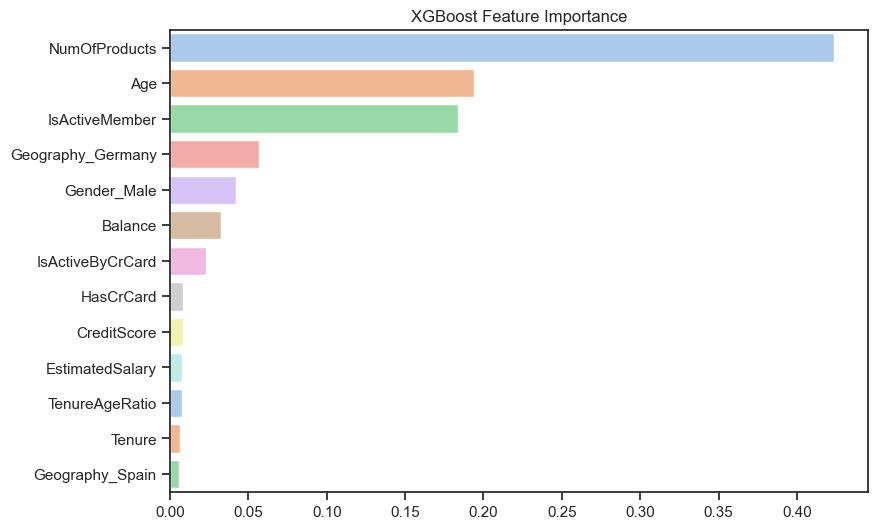

In [10]:
importances = best_xgb_clf.feature_importances_

feature_importance = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
sns.barplot(feature_importance,
            orient="h",
            palette='pastel')
plt.title('XGBoost Feature Importance')
plt.show()

### Тестирование модели и результаты по основным метрикам

Accuracy: 0.8654761543825608
Precision: 0.7434985968194574
Recall: 0.5644886363636363
F1: 0.641744045215987
ROC-AUC: 0.8899351353316537


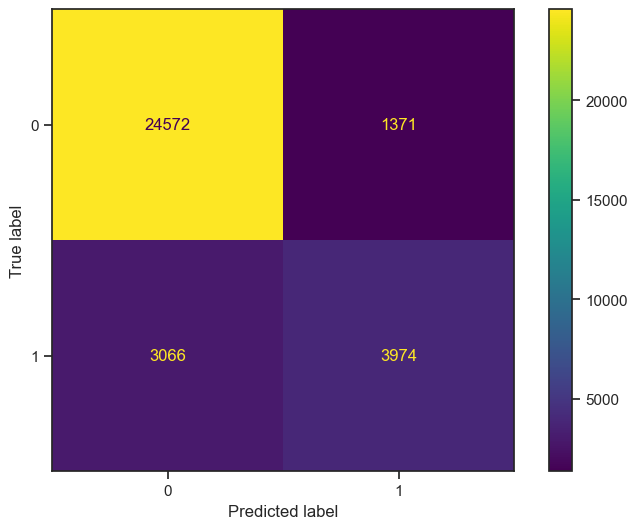

In [11]:
y_pred = best_xgb_clf.predict(X_test)
y_pred_proba = best_xgb_clf.predict_proba(X_test)[:, 1]
metrics_summary(y_pred, y_pred_proba, best_xgb_clf)

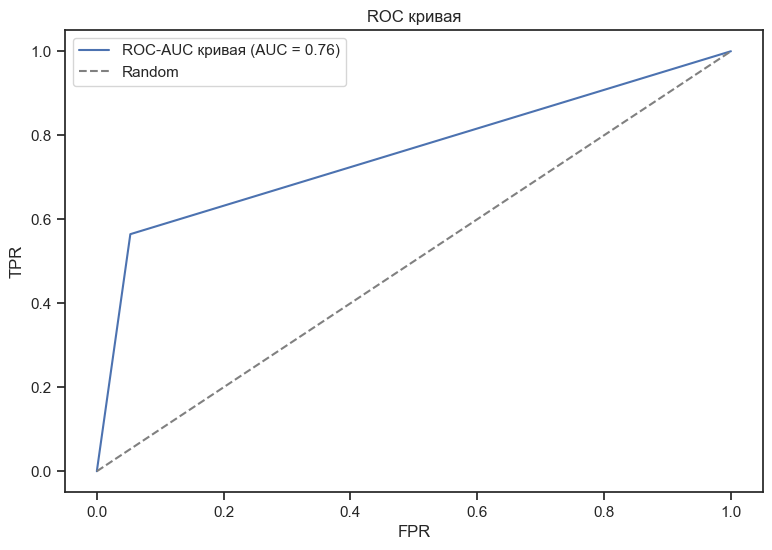

In [12]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label=f'ROC-AUC кривая (AUC = {roc_auc_score(y_test, y_pred):.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC кривая')
plt.legend()
plt.show()

### Kaggle Score

In [13]:
submission['Exited'] = best_xgb_clf.predict(test_df)
submission.to_csv("data/submissions/xgb_submission.csv", index=False)

![xgb_submission](data/img/xgb_submission.png)

## LightGBM

### Подбор параметров

In [14]:
lgbm_clf = LGBMClassifier(class_weight='balanced', verbose=-1)
start_time = time.time()
best_lgbm_clf, best_lgbm_params = find_best_parameters(X_train, y_train, lgbm_clf)
end_time = time.time()

In [15]:
print(f'Лучшие параметры: {best_lgbm_params}')
print(f'Общее время, затраченное на кросс-валидацию (в минутах): {(end_time - start_time)/60}')

Лучшие параметры: {'iterations': 200, 'learning_rate': 0.1, 'max_depth': 6, 'reg_lambda': 3}
Общее время, затраченное на кросс-валидацию (в минутах): 5.073703968524933


### Оценка важности признаков

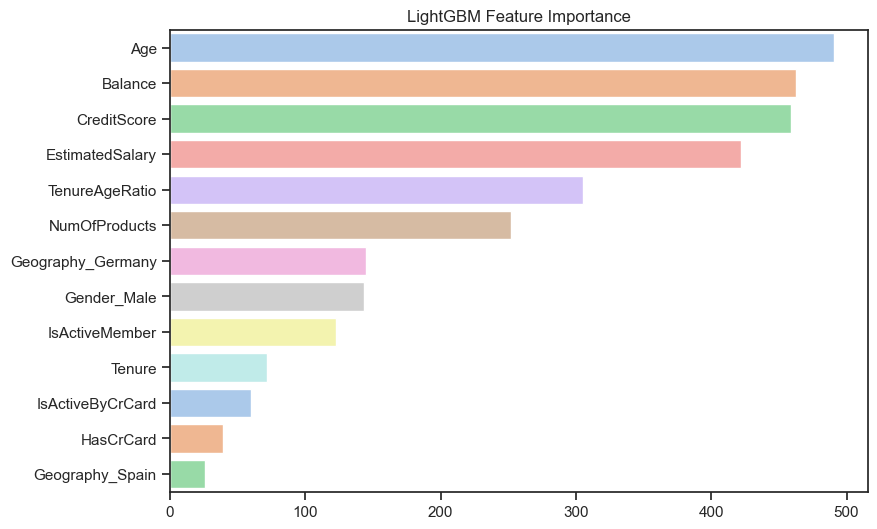

In [16]:
importances = best_lgbm_clf.feature_importances_

feature_importance = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
sns.barplot(feature_importance,
            orient="h",
            palette='pastel')
plt.title('LightGBM Feature Importance')
plt.show()

### Тестирование модели и результаты по основным метрикам

Accuracy: 0.8146317800078828
Precision: 0.5454902731381411
Recall: 0.7886363636363637
F1: 0.6449064932047857
ROC-AUC: 0.88957721834669


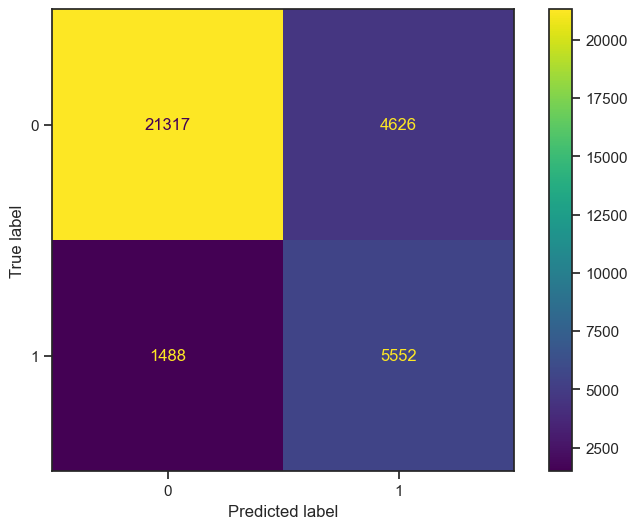

In [17]:
y_pred = best_lgbm_clf.predict(X_test)
y_pred_proba = best_lgbm_clf.predict_proba(X_test)[:, 1]
metrics_summary(y_pred, y_pred_proba, best_lgbm_clf)

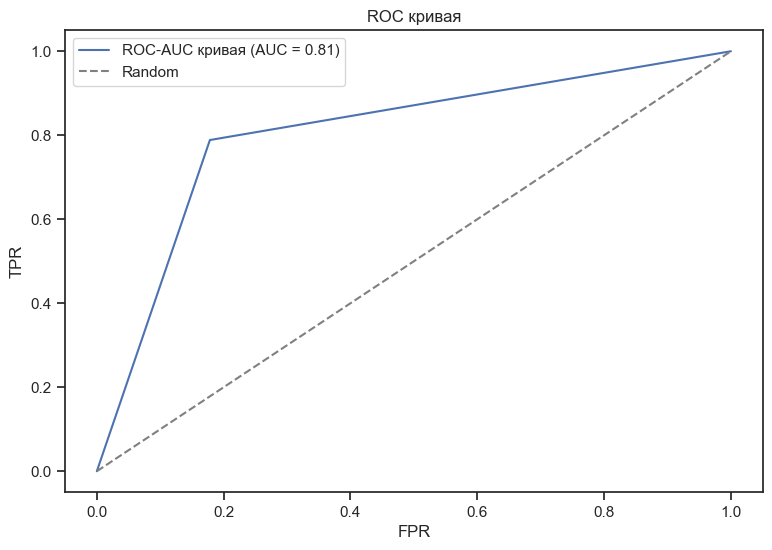

In [18]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label=f'ROC-AUC кривая (AUC = {roc_auc_score(y_test, y_pred):.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC кривая')
plt.legend()
plt.show()

### Kaggle Score

In [19]:
submission['Exited'] = best_lgbm_clf.predict(test_df)
submission.to_csv("data/submissions/lgbm_submission.csv", index=False)

![lgbm_submission](data/img/lgbm_submission.png)

## CatBoost

### Подбор параметров

In [20]:
catboost_clf = CatBoostClassifier(auto_class_weights='Balanced', loss_function='Logloss', verbose=False)
start_time = time.time()
best_catboost_clf, best_catboost_params = find_best_parameters(X_train, y_train, catboost_clf)
end_time = time.time()

In [21]:
print(f'Лучшие параметры: {best_catboost_params}')
print(f'Общее время, затраченное на кросс-валидацию (в минутах): {(end_time - start_time)/60}')

Лучшие параметры: {'iterations': 400, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 5}
Общее время, затраченное на кросс-валидацию (в минутах): 33.4401695171992


### Оценка важности признаков

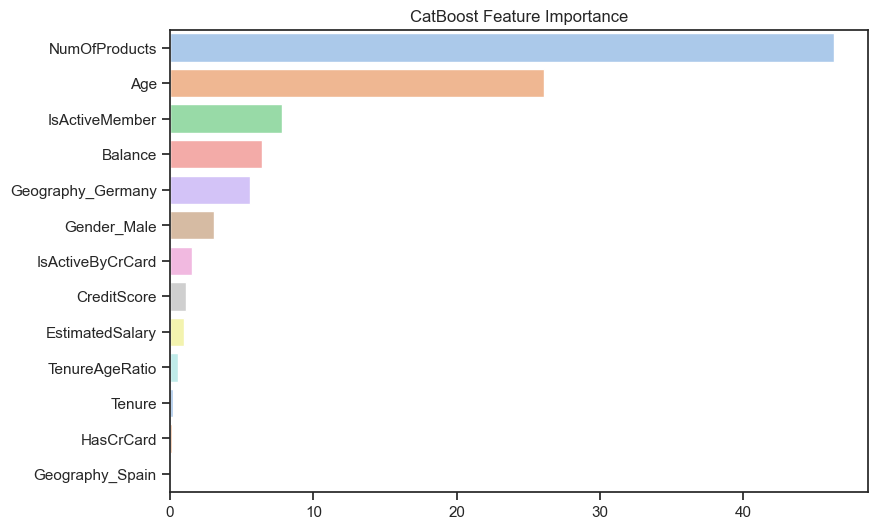

In [22]:
feature_names = best_catboost_clf.feature_names_
importances = best_catboost_clf.get_feature_importance(type='FeatureImportance')

feature_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)
sns.barplot(feature_importance,
            orient="h",
            palette='pastel')
plt.title('CatBoost Feature Importance')
plt.show()

### Тестирование модели и результаты по основным метрикам

Accuracy: 0.8110844980747658
Precision: 0.5389654175898275
Recall: 0.7947443181818182
F1: 0.6423282245565697
ROC-AUC: 0.8894452227873696


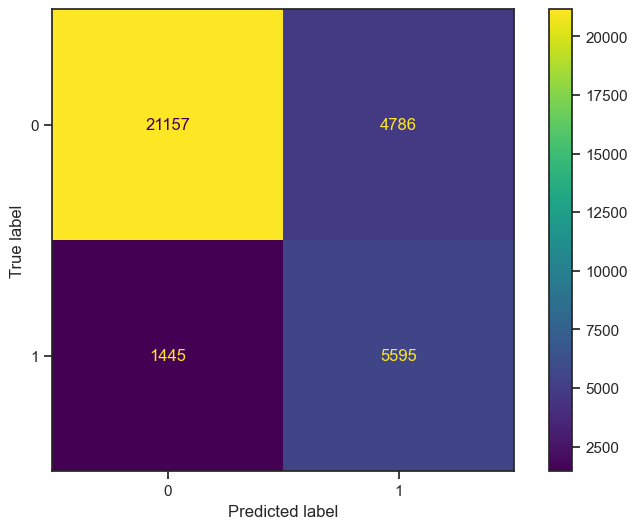

In [23]:
y_pred = best_catboost_clf.predict(X_test)
y_pred_proba = best_catboost_clf.predict_proba(X_test)[:, 1]
metrics_summary(y_pred, y_pred_proba, best_catboost_clf)

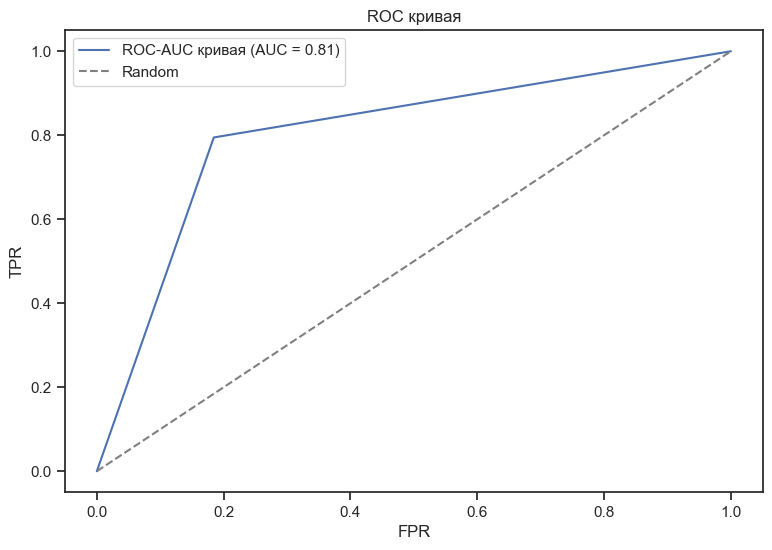

In [24]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label=f'ROC-AUC кривая (AUC = {roc_auc_score(y_test, y_pred):.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC кривая')
plt.legend()
plt.show()

### Kaggle Score

In [25]:
submission['Exited'] = best_catboost_clf.predict(test_df)
submission.to_csv("data/submissions/catboost_submission.csv", index=False)

![catboost_submission](data/img/catboost_submission.png)

# Результаты

- При построении моделей были использованы предобработанные данные. В предобработку входили кодировка категориальных признаков и генерация новых признаков на основе имеющихся;
- Были построены 3 модели - XGBoost, LightGBM, Catboost;
- Для подбора параметров моделей использовалась кросс-валидация;
- Модели CatBoost и LightGBM имеют почти одинаковый результат по целевой метрике. XGBoost модель имеет более плохой показатель ROC-AUC.

### Итоговые показатели метрики ROC-AUC для каждой модели на тестовой выборке

- **_XGBoost_** - 0.75556
- **_LightGBM_** - 0.80437
- **_CatBoost_** - 0.80494